# Zillow Clustering Project
## *Predicting Logerror*

by Kristofer Rivera
2022-04-08

## Project Overview

### Project Description

# Project Description and Goals
In this project, my goals are to determine drivers of error in Zillow home value predictions using data analysis and statistical testing and use this analysis to help build a machine learning model that can predict the error. 

### Project Goals
- Construct an ML Regression model incorporating clustering techniques that predicts logerror for Single Unit Properties that had a transaction in 2017 using attributes of the properties.
- Find key drivers of logerror.
- Make recommendations on what works or doesn't work in predicting logerror.


### Necessary Imports

In [1]:
#Imports for dataframe manipulation 
import pandas as pd

#Imports for statistical analysis
from scipy import stats
import statistics

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

#Imports for user defined functions
import wrangle as w
import explore as ex
import evaluate as ev

#Imports for preprocessing
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans

#Imports for modeling and evaluation
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

## Wrangle Zillow Data

I used the following SQL query to acquire the required data from the CodeUp MySQL server:

`SELECT
prop.*,
predictions_2017.logerror,
predictions_2017.transactiondate,
air.airconditioningdesc,
arch.architecturalstyledesc,
build.buildingclassdesc,
heat.heatingorsystemdesc,
landuse.propertylandusedesc,
story.storydesc,
construct.typeconstructiondesc
FROM properties_2017 prop
JOIN (
    SELECT parcelid, MAX(transactiondate) AS max_transactiondate FROM predictions_2017 GROUP BY parcelid) pred USING(parcelid)
JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid AND pred.max_transactiondate = predictions_2017.transactiondate
LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
LEFT JOIN storytype story USING (storytypeid)
LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
WHERE prop.latitude IS NOT NULL AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31';`. 
        
**Below is an example of the raw data acquired with my sql query (this is before any cleaning or prep):**

In [2]:
#Pre-defined function that gathers my data with a sql query and caches it locally as a csv, 
# Data is read from the csv on future calls of the function
df = w.acquire()
df.head()

Using cached csv...


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
# Summary of my raw data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77380 non-null  int64  
 1   parcelid                      77380 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49671 non-null  float64
 9   calculatedbathnbr             76771 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77184 non-null  float64
 13  f

**My original raw data frame contained 77380 rows and 68 columns.**

**To clean/prep the data, I did the following:**

1. Restricted data to only include single unit properties.
2. I renamed certain columns for clarity.
3. Dropped columns that I judged unhelpful or unnecessary.
4. Removed outliers that were skewing my data in order to achieve more normal distributions.
5. Changed data types where appropriate for readability or to denote categorical variables. (Floats to ints, ints to strings/objects.)
6. For clearer exploration, I converted the fips column into a county column, replacing the numerical values with the corresponding county names based on information gathered from https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
7. I also created a new age column calculated from the year_built column.
8. I imputed null values using mean or median for certain continuous variables such as home_sqft
9. I filled in null values for heating_system as 'None'


**Results:**
- 59962 Rows
- 23 Columns 
  
### Before exploration of variable relationships, I split the data into train, validate, and test data sets.

**Below is an example of what the data looks like after data cleaning and splitting:**

In [4]:
train, validate, test = w.wrangle_zillow()
train.head()

Using cached csv...


,bathrooms,bedrooms,building_quality,home_sqft,fips,latitude,longitude,lot_sqft,regionidcity,regionidcounty,...,structure_tax_value,assessed_value,land_tax_value,tax_amount,censustractandblock,logerror,heating_system,land_use,county,age
67577,2.0,2.0,6.0,815.0,6059.0,33747500.0,-117863000.0,7140.0,47568.0,1286.0,...,96379.0,167958.0,71579.0,2215.20,60590750022024.0,0.230662,None,Condominium,Orange,27.0
5673,2.0,2.0,8.0,1117.0,6037.0,33820500.0,-118342000.0,986080.0,54722.0,3101.0,...,30210.0,95425.0,65215.0,1209.14,60376511022012.0,-0.002682,Central,Condominium,Los Angeles,53.0
16346,3.0,4.0,6.0,1469.0,6037.0,33805856.0,-118124873.0,6145.0,46298.0,3101.0,...,132547.0,443207.0,310660.0,5404.60,60375742012000.0,0.067708,Floor/Wall,Single Family Residential,Los Angeles,64.0
24690,3.0,4.0,6.0,2030.0,6059.0,33606164.0,-117670415.0,8662.0,12773.0,1286.0,...,168642.0,412426.0,243784.0,4196.14,60590320031009.0,0.002729,None,Single Family Residential,Orange,48.0
29587,1.0,2.0,6.0,864.0,6059.0,33844336.0,-117962041.0,7200.0,16764.0,1286.0,...,54268.0,444000.0,389732.0,5314.98,60590868022006.0,0.017012,None,Single Family Residential,Orange,68.0


- Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data. 
- The validate is used to verify that our models built are not overfit to the train dataset. 
- The test set is used to give an estimate of how this model will perform on data is has never seen in the future.

## Exploratory Analysis ##
**I decided to create an age column calculated based on the year built for easier exploration.**

**I then started exploratory analysis by examning the correlations of all by variables with assessed_value.**

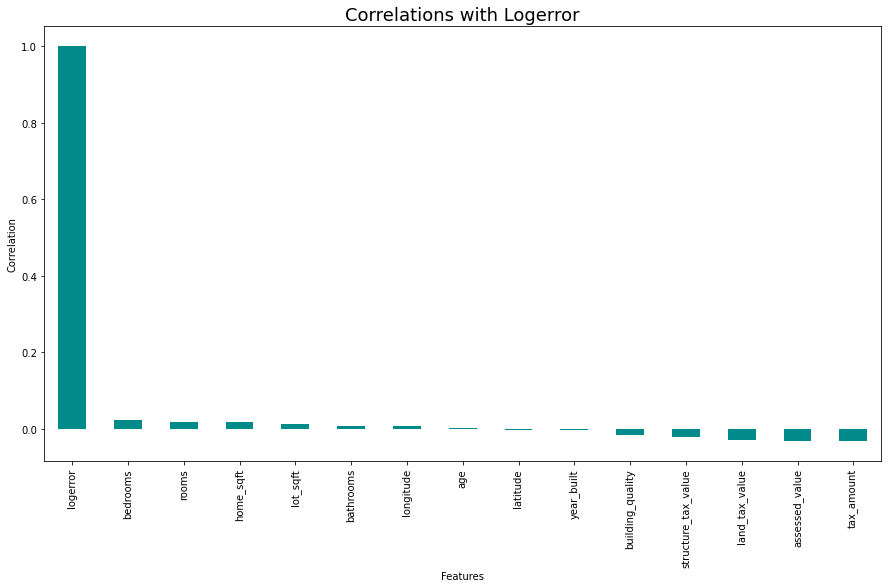

In [5]:
df = train.copy()
ex.plot_correlations(train)

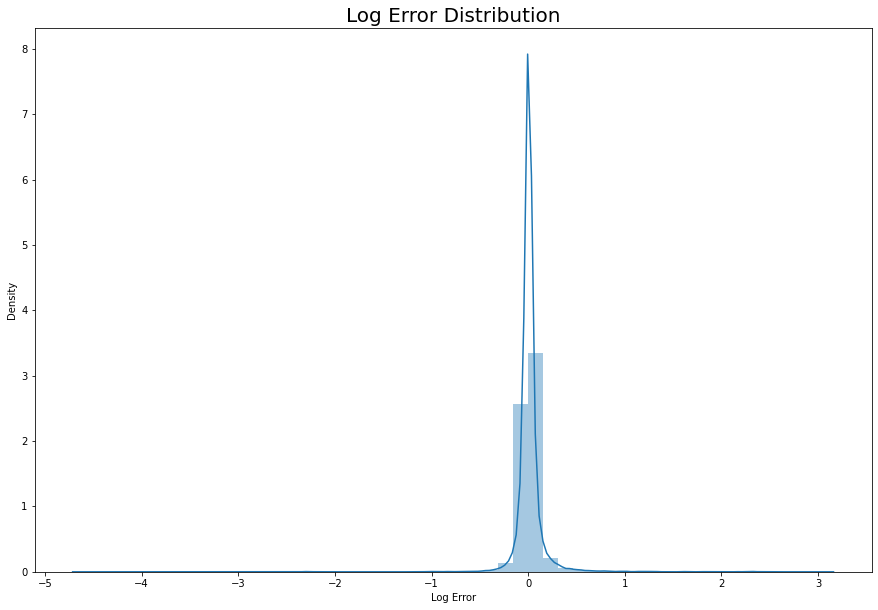

In [6]:
# Let's take a look at the overall log error distribution

plt.figure(figsize= (15, 10))
sns.distplot(df.logerror)
plt.title('Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')
plt.show()

**Takeaways:**
- This gave me a good starting point by showing which variables are most highly correlated with my target: 
    - home_sqft, number of bedrooms, assessed_value and tax_amount are some of the stronger correlations.

**To guide my exploration, I sought to answer these initial questions:**

1. Does logerror differ significantly for properties based on their county?
2. Is the age of the property linearly correlated with logerror?
3. Is home square feet linearly correlated with logerror?
4. Is the number of building quality linearly correlated with logerror?

### Question 1: Does logerror differ significantly for properties based on their county?

#### Los Angeles logerror vs. population logerror? 

$H0$: There is no significant difference between the county logerror and the total population logerror.

$Ha$: There is a signifcant difference between the county logerror and the total population logerror.

In [7]:
# Set up variables for the county logerrors
la = train[train.county == 'Los Angeles']
orange = train[train.county == 'Orange']
ventura = train[train.county == 'Ventura']

In [8]:
alpha = .05 / 2
t, p = stats.mannwhitneyu(la.logerror, df.logerror, alternative='two-sided')

if p < alpha:
    print('We reject the null hypothesis with 95% confidence.')
else:
    print('We fail to reject the null hypothesis. There is a significant difference.')

We fail to reject the null hypothesis. There is a significant difference.


**Takeaway:**
- There is indeed a significant difference between logerror for properties of different counties.

## Question 2: Is the age of the property linearly correlated with logerror?

$H0$: There is no linear correlation between age and logerror.

$Ha$: There is a linear correlation between age and logerror.

In [9]:
# Predefined function that conducts a pearsonr test and prints out the results
ex.pearsonr(df.age, df.logerror)

The correlation value between the two variables is 0.002768 and the P-Value is 0.6157069248371366.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.


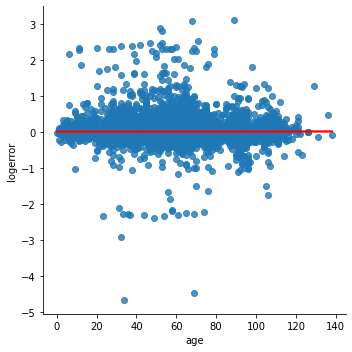

In [10]:
sns.lmplot(data = df, x='age', y='logerror', line_kws={'color':'red'})
plt.show()

**Takeaway:**
- There is not a significant linear correlation between age and logerror.

## Question 3: Is home square feet linearly correlated with logerror?

$H0$: There is no linear correlation between home square feet and logerror.

$Ha$: There is a linear correlation between home square feet and logerror.

In [11]:
ex.pearsonr(df.home_sqft, df.logerror)

The correlation value between the two variables is 0.0178 and the P-Value is 0.0012484505383029078.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


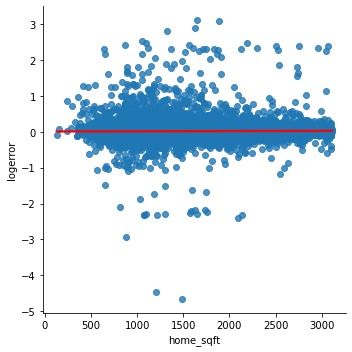

In [12]:
sns.lmplot(data = df, x='home_sqft', y='logerror', line_kws={'color':'red'})
plt.show()

Takeway: 
 
- While the statistical test indicates that there is a liner correlation it is a very slight one and not all that significant.

## Question 4: Is building quality linearly correlated with logerror?

$H0$: There is no linear correlation between building quality and logerror.

$Ha$: There is a linear correlation between building quality and logerror.

In [13]:
ex.pearsonr(df.building_quality, df.logerror)

The correlation value between the two variables is -0.0143 and the P-Value is 0.00953104892810659.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


**Takeways: There is a very small linear correlation in the negative direction between these two variables.**

## Cluster and Model

### Preprocessing

**Create Dummy Variables for Categorical Columns**

In [14]:
cols = ['heating_system', 'land_use', 'county']
train = w.get_dummies(train, cols)
validate = w.get_dummies(validate, cols)
test = w.get_dummies(test, cols)

**Scale Data**

In [15]:
# Scale data using MinMax Scaler
## Before clustering I'm going to create scaled versions of my train, validate, test splits
## I'll then make a copy of the train sclaed data frame to use for creating clusters

columns_to_scale = list(train.select_dtypes(include=['float64']).columns)

train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test, columns_to_scale)

In [16]:
train_scaled.head()

,bathrooms,bedrooms,building_quality,home_sqft,fips,latitude,longitude,lot_sqft,regionidcity,regionidcounty,...,heating_system_Gravity,heating_system_None,heating_system_Radiant,heating_system_Solar,heating_system_Yes,land_use_Mobile Home,land_use_Single Family Residential,land_use_Townhouse,county_Orange,county_Ventura
67577,0.285714,0.285714,0.454545,0.230460,6059.0,0.275799,0.837155,0.000962,47568.0,1286.0,...,0,1,0,0,0,0,0,0,1,0
5673,0.285714,0.285714,0.636364,0.331768,6037.0,0.325149,0.568400,0.141401,54722.0,3101.0,...,0,0,0,0,0,0,0,0,0,0
16346,0.428571,0.571429,0.454545,0.449849,6037.0,0.315249,0.690225,0.000819,46298.0,3101.0,...,0,0,0,0,0,0,1,0,0,0
24690,0.428571,0.571429,0.454545,0.638041,6059.0,0.180253,0.945210,0.001180,12773.0,1286.0,...,0,1,0,0,0,0,1,0,1,0
29587,0.142857,0.285714,0.454545,0.246897,6059.0,0.341262,0.781586,0.000971,16764.0,1286.0,...,0,1,0,0,0,0,1,0,1,0


## Creating Clusters

In [17]:
# Creating a copy of train data frame to be used for creating clusters
cluster_df = train_scaled.copy()

### Assign Variable Groups to be used as Clusters

**Cluster Groups: Age and Location, Property Size, Property Value and Quality**

#### Cluster 1: Age and Location

In [18]:
X = cluster_df[['age', 'latitude', 'longitude']]

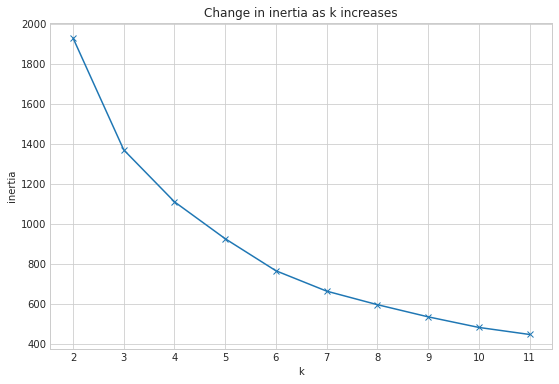

In [19]:
ex.elbow_method(X)

**Based on this visualization I went with 5 clusters.**

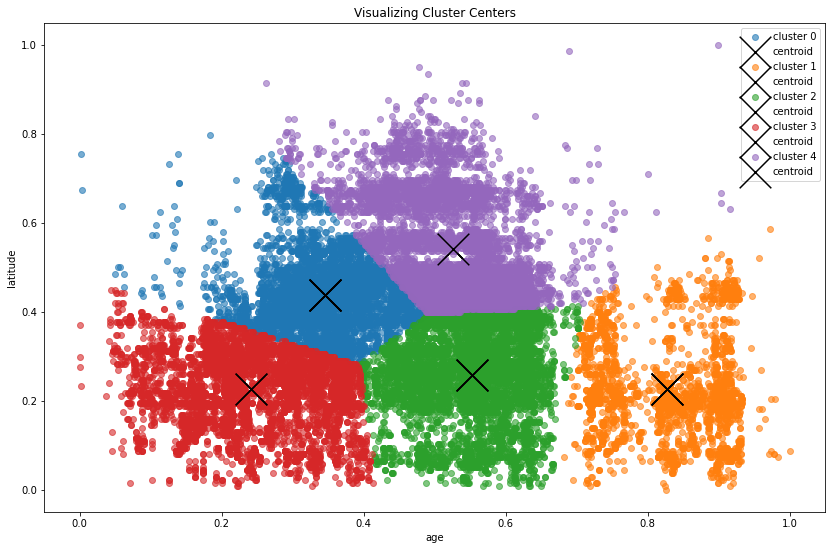

In [20]:
ex.cluster(cluster_df, 'age', 'latitude', 5)

In [21]:
#Create the KMeans model
kmeans = KMeans(n_clusters = 5, random_state = 123)

#Fit the model
kmeans.fit(X)

#Make predictions and assign the values to the original train data set
train['age_location_cluster'] = kmeans.predict(X)

#### Cluster 2: Property Size

In [22]:
#Copy the train data set and remove unnecessary vars
X = cluster_df[['home_sqft', 'bedrooms', 'bathrooms']]


In [23]:
#Create the KMeans model
kmeans = KMeans(n_clusters = 4, random_state = 123)

#Fit the model
kmeans.fit(X)

#Make predictions and assign values to original train data set
train['size_cluster'] = kmeans.predict(X)

#### Cluster 3: Property Value and Quality

In [24]:
#Copy the train data set and remove unnecessary vars
X = cluster_df[['assessed_value', 'building_quality']]

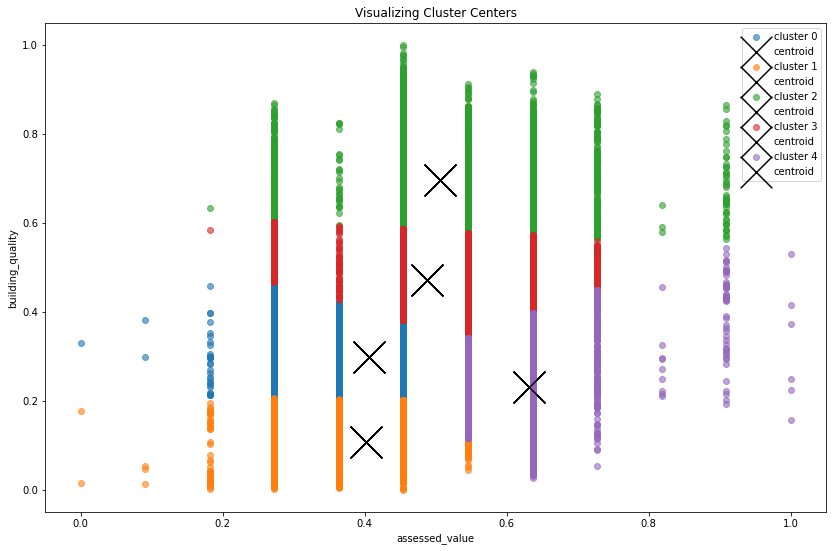

In [25]:
ex.cluster(cluster_df, 'assessed_value', 'building_quality', 5)

In [26]:
#Create the KMeans model
kmeans = KMeans(n_clusters = 5, random_state = 123)

#Fit the model
kmeans.fit(X)

#Make predictions and assign values to original train dataset
train['value_quality_cluster'] = kmeans.predict(X)

## Modeling

**For my MVP I decided to model using a limited set of features including my clusters.**

In [27]:
#Columns to be used for modeling
mvp = ['bathrooms', 'bedrooms', 'building_quality', 'home_sqft',
       'latitude', 'longitude','assessed_value', 'age']
    

In [28]:
#First Iteration - split into X and Y using scaled data and only select variables
X_train, y_train = train_scaled[mvp], train_scaled.logerror
X_validate, y_validate = validate_scaled[mvp], validate_scaled.assessed_value
X_test, y_test = test_scaled[mvp], test_scaled.assessed_value

### Add clusters to the data sets

In [29]:
## Group 1

#Set up clusters for train
cols = ['age', 'latitude', 'longitude']
X = X_train[cols]
#Create the KMeans model
kmeans = KMeans(n_clusters = 5, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign the values to the original train data set
X_train['age_location_cluster'] = kmeans.predict(X)

# Set up clusters for validate
X = X_validate[cols]
#Create the KMeans model
kmeans = KMeans(n_clusters = 5, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign the values to the original train data set
X_validate['age_location_cluster'] = kmeans.predict(X)

#######

# Set up clusters for tets
X = X_test[cols]
#Create the KMeans model
kmeans = KMeans(n_clusters = 5, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign the values to the original train data set
X_test['age_location_cluster'] = kmeans.predict(X)

## Group 2


#Set up clusters for train
cols = ['home_sqft', 'bedrooms', 'bathrooms']
X = X_train[cols]
#Create the KMeans model
kmeans = KMeans(n_clusters = 4, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign values to original train data set
X_train['size_cluster'] = kmeans.predict(X)

# Set up clusters for validate
#Create the KMeans model
X = X_validate[cols]
kmeans = KMeans(n_clusters = 4, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign values to original train data set
X_validate['size_cluster'] = kmeans.predict(X)

# Set up clusters for test
#Create the KMeans model
X = X_test[cols]
kmeans = KMeans(n_clusters = 4, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign values to original train data set
X_test['size_cluster'] = kmeans.predict(X)

# Group 3
#Set up clusters for train
cols = ['assessed_value', 'building_quality']
X = X_train[cols]
#Create the KMeans model
kmeans = KMeans(n_clusters = 5, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign values to original train dataset
X_train['value_quality_cluster'] = kmeans.predict(X)

#set up for validate

X = X_validate[cols]
#Create the KMeans model
kmeans = KMeans(n_clusters = 5, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign values to original train dataset
X_validate['value_quality_cluster'] = kmeans.predict(X)

#Set up for test

X = X_test[cols]
#Create the KMeans model
kmeans = KMeans(n_clusters = 5, random_state = 123)
#Fit the model
kmeans.fit(X)
#Make predictions and assign values to original train dataset
X_test['value_quality_cluster'] = kmeans.predict(X)

#### Clusters added to the data sets

#### Calculate our baseline
- Will caculate baseline based on both the mean and median and evaluate which has the lowest RMSE to decide which will be the baseline our model needs to beat.

In [45]:
#First convert y_train into Dataframes so the baselines can be easily calculated with pandas
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test =pd.DataFrame(y_test)

# Create new data frame to hold my in sample predictions and the same for out of sample
predictions_train = y_train.copy()
predictions_train = predictions_train.rename(columns={'logerror':'actual'})
predictions_validate = y_validate.copy()
predictions_validate = predictions_validate.rename(columns={'logerror':'actual'})
predictions_test = y_test.copy()
predictions_test = predictions_test.rename(columns={'logerror':'actual'})


#Calculate based on mean and add baseline predictions to a the train data frame holding predictions
baseline_mean = train.logerror.mean()
predictions_train['baseline_mean'] = baseline_mean
predictions_validate['baseline_mean'] = baseline_mean
predictions_test['baseline_mean'] = baseline_mean

#Calculate based on median and add baseline predictions to the train data frame holding predictions
baseline_median = train.logerror.median()
predictions_train['baseline_median'] = baseline_median
predictions_validate['baseline_median'] = baseline_median
predictions_test['baseline_median'] = baseline_median

In [48]:
predictions_train.head()

,actual,baseline_mean,baseline_median
67577,0.629947,0.015492,0.005517
5673,0.599863,0.015492,0.005517
16346,0.608938,0.015492,0.005517
24690,0.600561,0.015492,0.005517
29587,0.602402,0.015492,0.005517


**The median is lower indicates a more predictive model so we will use the mean as our baseline.**

## Regression Models - MVP

**For my MVP I trained and fit the 4 models listed here:**

Model 1 - Simple Model (Ordinary Least Squares)

Model 2 - LASSO + LARS

Model 3 - Polynomial Regression

Model 4 - Generalized Linear Model


**These were the evaluation results:**

RMSE using OLS
Validate/Out-of-Sample:  .012995349


RMSE using LassoLars
Validate/Out-of-Sample:  .00029919

RMSE using Polynomial Features
Validate/Out-of-Sample:  .000991953

RMSE using Generalized Linear Model
Validate/Out-of-Sample:  .001965349

### Below I'll showcase the code for how I built my top 3 models:

### Model 1 - Simple Ordinary Least Squares

In [60]:
## Model 1 - Simple Model -- Ordinary Least Squares

#Create model
lm = LinearRegression(normalize = True)

#Fit model to train
lm.fit(X_train, y_train)

#Make predictions on test, validate
predictions_train['ols_model'] = lm.predict(X_train)
predictions_validate['ols_model'] = lm.predict(X_validate)

In [61]:
predictions_validate.head()

,assessed_value,baseline_mean,baseline_median,ols_model,polynomial_model,glm
8418,0.569266,0.015492,0.005517,0.602016,0.600806,0.601191
45517,0.502599,0.015492,0.005517,0.601583,0.603381,0.601095
13623,0.092867,0.015492,0.005517,0.602731,0.603099,0.601921
56789,0.365721,0.015492,0.005517,0.601550,0.602000,0.602176
24494,0.318911,0.015492,0.005517,0.602386,0.602957,0.603015


### Model 3 - Polynomial Regression

In [53]:
## Create the polynomial features

# Create polynomial features
pf = PolynomialFeatures(degree=2)

# fit to my features and create a new version of X_train with transformed features
X_train_poly = pf.fit_transform(X_train)

# Transform features on X_validate and X_test
X_validate_poly = pf.transform(X_validate)
X_test_poly = pf.transform(X_test)

## Create another simple linear regression model

#Create model
lm2 = LinearRegression(normalize=True)

# Fit to training set with polynomial features
lm2.fit(X_train_poly, y_train)

# Make predictions on train and validate
predictions_train['polynomial_model'] = lm2.predict(X_train_poly)
predictions_validate['polynomial_model'] = lm2.predict(X_validate_poly)

predictions_validate.head()

,assessed_value,baseline_mean,baseline_median,ols_model,polynomial_model
8418,0.569266,0.015492,0.005517,0.602016,0.600806
45517,0.502599,0.015492,0.005517,0.601583,0.603381
13623,0.092867,0.015492,0.005517,0.602731,0.603099
56789,0.365721,0.015492,0.005517,0.601550,0.602000
24494,0.318911,0.015492,0.005517,0.602386,0.602957


### Model 4 - Generalized Linear Model -- TweedieRegressor

In [56]:
# create the model
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to training data
glm.fit(X_train, y_train)

# make predictions on validate
predictions_train['glm'] = glm.predict(X_train)
predictions_validate['glm'] = glm.predict(X_validate)

predictions_validate.head()

,assessed_value,baseline_mean,baseline_median,ols_model,polynomial_model,glm
8418,0.569266,0.015492,0.005517,0.602016,0.600806,0.601191
45517,0.502599,0.015492,0.005517,0.601583,0.603381,0.601095
13623,0.092867,0.015492,0.005517,0.602731,0.603099,0.601921
56789,0.365721,0.015492,0.005517,0.601550,0.602000,0.602176
24494,0.318911,0.015492,0.005517,0.602386,0.602957,0.603015


**The Simple OLS Model had the lowest RMSE score for both in-sample and out-of-sample data, so I chose it as my best model, but it still didn't beat baseline.**

## Conclusions
### Models were not able to beat the baseline.

**Discovered some key drivers of logerror though they are not very predictive:**
- Having more square footage.
- Having more bedrooms and bathrooms correlates with logerror. 
- Location is a driver for logerror.

## Recommendations 
- Due to relatively low accuracy of current models, I wouldn't recommend using them for investment purposes unless improvements can be made.

### Next Steps -- If I had more time I would....
- Conduct further feature engineering and continue experimenting with clusters.
- Try new models using different paramaters and feature combinations